In [1]:
import numpy as np
import matplotlib.pyplot as plt
from features import *
from numba import jit
from scipy.spatial import ConvexHull
%matplotlib inline
plt.gray()


# ROC Curves
ROC curves are tools used to compare binary classifiers. In general, it is insufficient to use accuracy as a metric for classification, as it offers very little information, and as soon as there is any class imbalance it tends to be meaningless. For example, if we have 100000 points, with 10 positive class, and 99990 negative class points, if our classifier chooses that everything is negative, it will have a accuracy of 99.99%, even though it is really not very good. ROC curves prevent that by looking at the true positive and false positive rates at different thresholds. Any point that lies in the Pareto Frontier of the ROC curve is a potential best classifier; it is either better in TPR or FPR than all others. This is particularly important in feature detection, where there are thousands or millions of possible locations for the features, but often only a few occurences.

Note in ROC graphs, $\text{TPR} = \frac{\#\text{True Positive}}{\#\text{Positive}}$ is on the y-axis, and $\text{FPR} = \frac{\#\text{False Positive}}{\#\text{Negative}}$ is on the x-axis.

In [2]:
def compute_roc(scores, labels):
    # Labels should be 0, 1
    scores = scores.reshape(-1)
    labels = labels.reshape(-1)
    sorted_labels = labels[(-scores).argsort()]
    tpr = np.cumsum(sorted_labels) / sorted_labels.sum()
    fpr = np.cumsum(sorted_labels==0) / (sorted_labels==0).sum()
    return tpr, fpr
def compute_snr(im, noisy_im):
    sig = ((im-noisy_im)**2).mean()
    if sig==0:
        return np.inf
    return im.mean() / sig
def noisy(im, std):
    M = im.max()
    m = im.min()
    return np.clip(im + np.random.randn(*im.shape)*std, m, M)

In [3]:
im = plt.imread('./characters.png').mean(2)
t = plt.imread('./T.png')
gt = np.loadtxt('./labels.txt')

## Experiments
The pattern that I have chosen to detect is the letter "h" in a snippet of text. There are 38 of them in this portion, but there are about 400000 possible locations for them. If we used accuracy, we would find that the accuracy is practically 100 percent if our threshold is $\infty$, as there are so few "h"s. The ROC curve fixes this problem by looking at the TPR and FPR, so it is a better way of comparing classifiers. In addition to the basic text, I use the same text, but with the contrast decreasing to 0 as it goes to the right. In other words, I take a linear function $f$ that is zero on the left size and 1 on the right side, and take $I' = I(x,y)f(x) + 0.5(1-f(x)$. This is done to examine the behavior of the different feature detection algorithms under different circumstances.

To create different ROC curves, I add Gaussian noise with different standard deviations, and clip the resulting image to make sure it lies between zero and one. One thing to note is that a zero/low noise classifier will probably achieve 100% accuracy, so the ROC curve will only have the points (0,0), (1,1), and (0,1) (and the lines connecting them).

Text(0.5,1,'Pattern to detect')

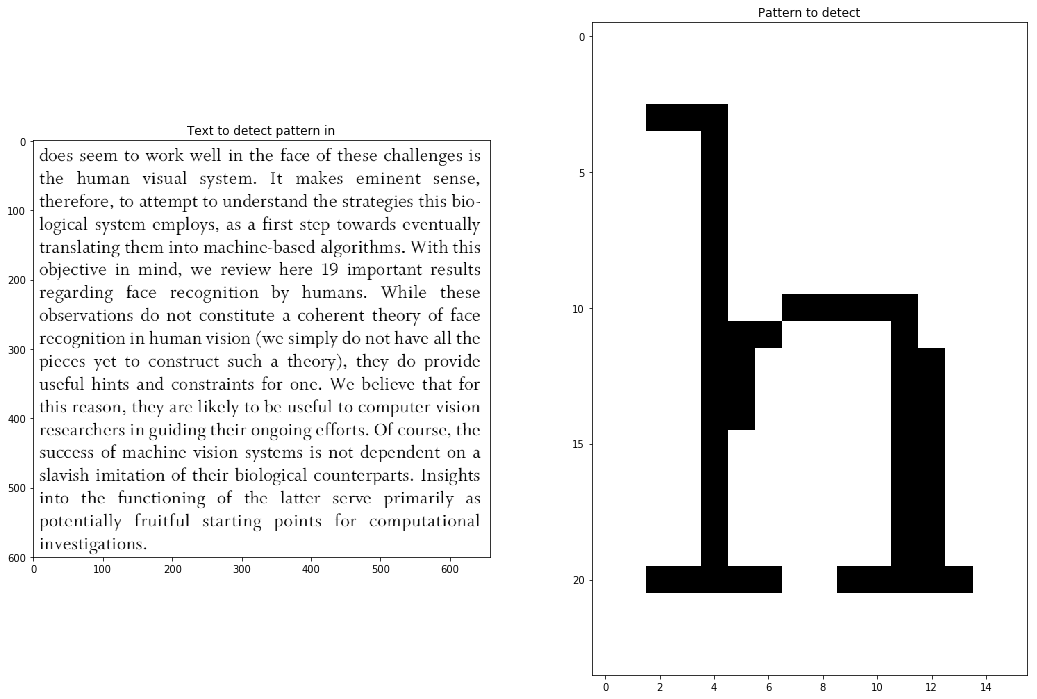

In [4]:
fig, ax = plt.subplots(ncols=2,figsize=(18,12))
ax[0].imshow(im)
ax[1].imshow(t)
ax[0].set_title('Text to detect pattern in')
ax[1].set_title('Pattern to detect')

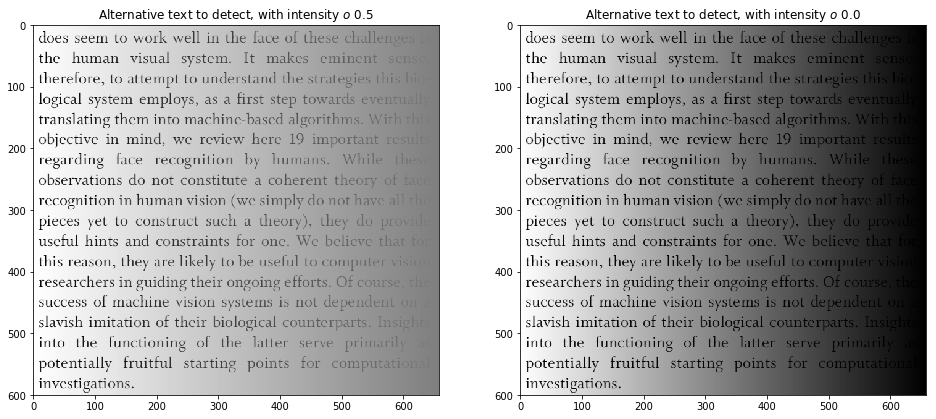

In [5]:
fig = plt.figure(figsize=(16,8))
n = im.shape[1]
sc = np.arange(n)[::-1][None] / n
im2 = im*sc + 0.5*(1-sc)
im3 = im*sc
ax = plt.subplot(1,2,1)
ax.set_title('Alternative text to detect, with intensity $\to$ 0.5')
ax.imshow(im2)
ax = plt.subplot(1,2,2)
ax.set_title('Alternative text to detect, with intensity $\to$ 0.0')
ax.imshow(im3)

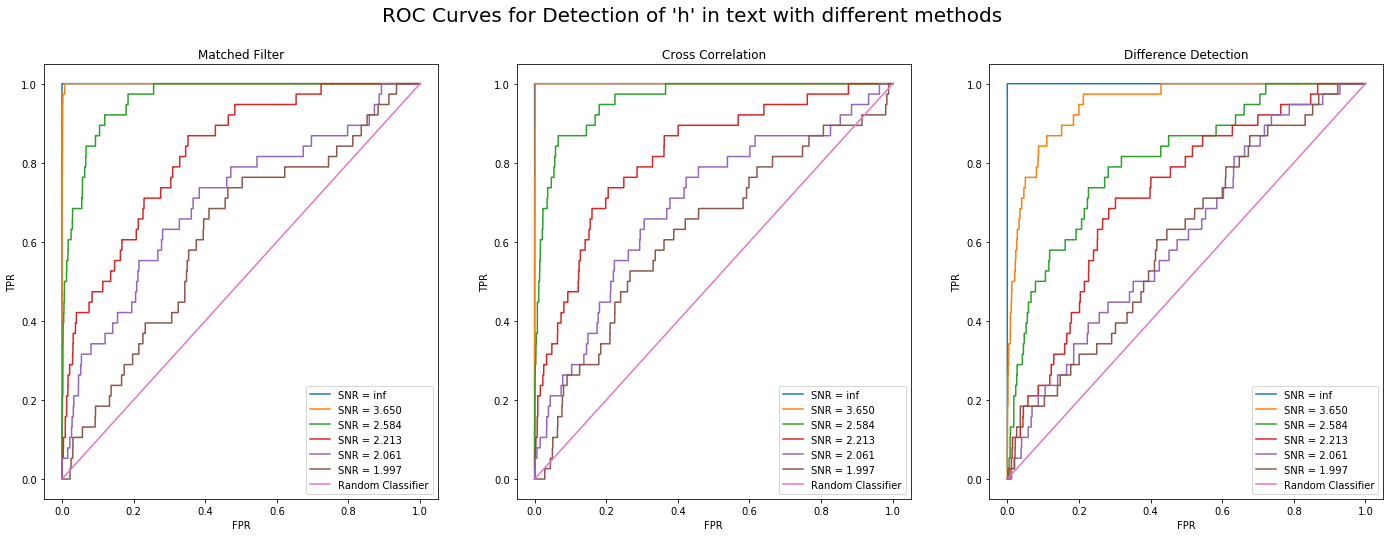

In [6]:
fig, ax = plt.subplots(ncols=3, figsize=(24,8))
fs = [matched_filter, cross_correlation, difference_detection]
names = ['Matched Filter', 'Cross Correlation', 'Difference Detection']
fig.suptitle("ROC Curves for Detection of 'h' in text with different methods", fontsize=20)
for i in range(3):
    np.random.seed(28984)
    for sig in [0, 1, 2, 4, 8, 16]:
        nim = noisy(im, sig)
        fd = fs[i](nim, t)
        tpr, fpr = compute_roc(fd, gt)
        ax[i].plot(fpr, tpr, label='SNR = %.3f'%compute_snr(im, nim))
    ax[i].plot([0,1],[0,1], label='Random Classifier')
    ax[i].legend(loc='best')
    ax[i].set_title(names[i])
    ax[i].set_xlabel('FPR')
    ax[i].set_ylabel('TPR')

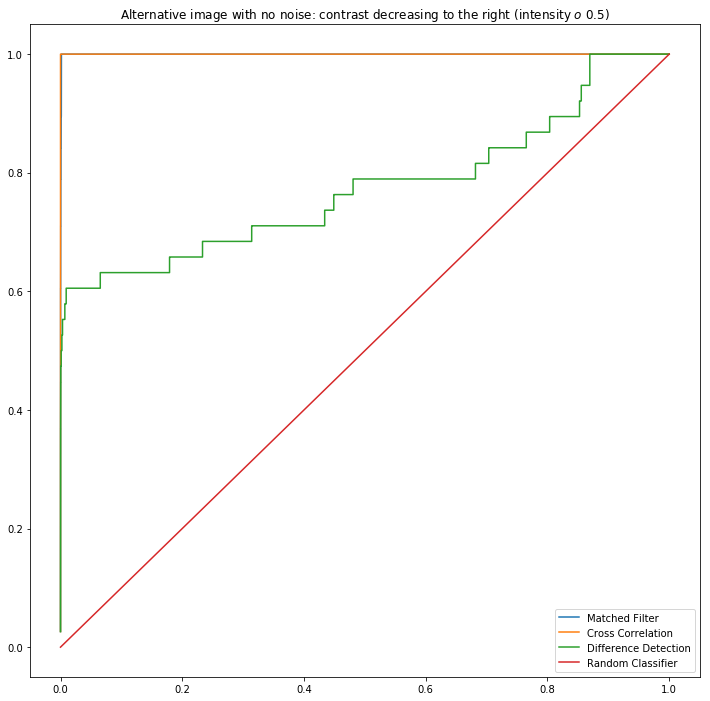

In [7]:
fig, ax = plt.subplots(figsize=(12,12))
fs = [matched_filter, cross_correlation, difference_detection]
names = ['Matched Filter', 'Cross Correlation', 'Difference Detection']
for i in range(3):
    np.random.seed(28984)
    fd = fs[i](im2, t)
    tpr, fpr = compute_roc(fd, gt)
    ax.plot(fpr, tpr, label=names[i])
ax.plot([0,1],[0,1], label='Random Classifier')
ax.set_title('Alternative image with no noise: contrast decreasing to the right (intensity $\to$ 0.5)')
ax.legend(loc='best')

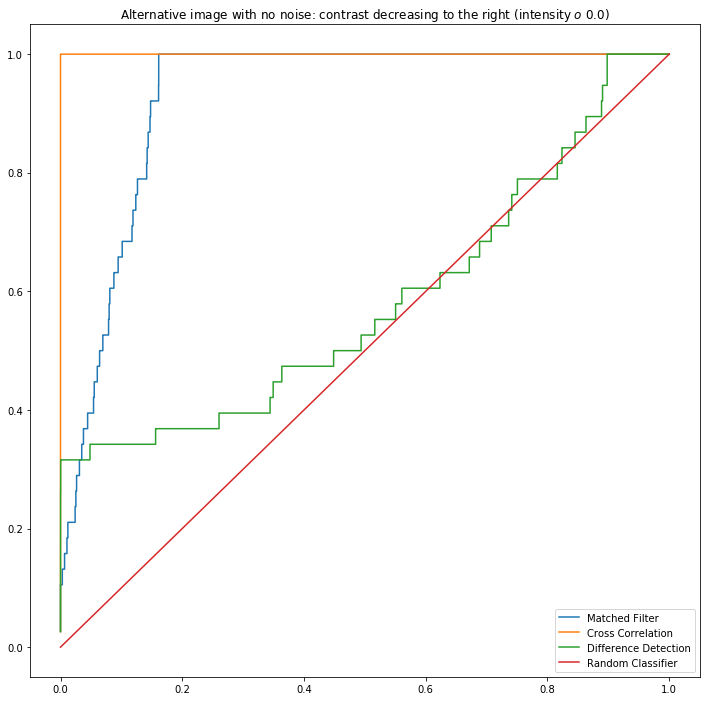

In [8]:
fig, ax = plt.subplots(figsize=(12,12))
fs = [matched_filter, cross_correlation, difference_detection]
names = ['Matched Filter', 'Cross Correlation', 'Difference Detection']
for i in range(3):
    np.random.seed(28984)
    fd = fs[i](im3, t)
    tpr, fpr = compute_roc(fd, gt)
    ax.plot(fpr, tpr, label=names[i])
ax.plot([0,1],[0,1], label='Random Classifier')
ax.set_title('Alternative image with no noise: contrast decreasing to the right (intensity $\to$ 0.0)')
ax.legend(loc='best')

## Discussion
Here, we can see that all algorithms can perfectly detect the features with no noise. As we slightly increase the noise, using a 2-norm of the patch difference immediately performs much worse, as expected, and cross-correlation and matched filtering work the best. At higher noises, matched filters and cross-correlation work similarly, but patch differences work much worse. 

We see something similar to that in the decreasing contrast example: matched filters and cross-correlation handle it acceptably, while the 2-norm difference meaasure is unable to achieve a perfect score. This is somewhat expected, as the difference between the patches will be much higher on the right than left, so a uniform threshold will not be able to caputre the features on the right. We can see if we decrease the intensity to zero instead of 0.5 on the right, the matched filter is no longer perfect, as the responses will also decrease to zero, rather than only 0.5.

From this exploration, it seems that in general, normalized cross-correlation is a more robust measure of patch similarity than a 2-norm difference or matched filter.